- <a href='#completion_challenge'>1 Completion Challenge</a>
    - <a href='#explore_questions'>1.1 Explore questions</a>
    - <a href='#challenge_classes'>1.2 Challenge classes</a>
- <a href='#ngram_Language_models'>2 Ngram Language models</a>
    - <a href='#holmes_Training_Data'>2.1 Holmes traing data</a>
    - <a href='#language_model_classes'>2.2 Ngram model classes</a>
    - <a href='#ngram_hyper_parameters'>2.3 Ngram hyper-parameters</a>
    - <a href='#ngram_accuracy'>2.4 Ngram accuracy</a>
    - <a href='#trigram_error_analysis'>2.5 Trigram error analysis</a>
        - <a href='#ngram_hyper_1'>2.3.1 Amount of training data</a>
        - <a href='#ngram_hyper_2'>2.3.2 The threshold frequency for unknown words</a>
        - <a href='#ngram_hyper_3'>2.3.3 The size of the discount applied to observed trigrams</a>
    - <a href='#trigram_error_analysis'>2.4 Trigram error analysis</a>
- <a href='#word_similarity'>3 Word similarity method</a>
    - <a href='#word_embeddings'>3.1 Load word embeddings</a>
    - <a href='#similarity_classes'>3.2 Similarity model classes</a>
        - <a href='#Similarity_acc'>3.2.1 Similarity model accuracy</a>
    - <a href='#similarity_hyper_parameters'>3.3 Similarity method hyper-parameters</a>
        - <a href='#embeddings_count'>3.3.1 The number of the embeddings used to calculate the similarity</a>
    - <a href='#similarity_error_analysis'>3.4 similarity method error analysis</a>
- <a href='#Common_error_analysis'>4 Common error analysis</a>
 

In [109]:
from nltk import word_tokenize as tokenize
import numpy as np
import os,random,math
import pickle

In [110]:
import matplotlib.pyplot as plt
%matplotlib inline

In [111]:
from gensim.models import KeyedVectors

In [243]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\randa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [271]:
import string 

<a id='completion_challenge'></a> 

## 1 Completion Challenge   

<a id='explore_questions'></a> 

### 1.1 Explore questions

In [112]:
#have a look at the sentence completion challenge questions
parentdir="../lab2resources/sentence-completion" 

import pandas as pd, csv
questions=os.path.join(parentdir,"testing_data.csv")
answers=os.path.join(parentdir,"test_answer.csv")

with open(questions) as instream:
    csvreader=csv.reader(instream)
    lines=list(csvreader)
    
qs_df=pd.DataFrame(lines[1:],columns=lines[0])



In [113]:
qs_df

,id,question,a),b),c),d),e)
0,1,I have it from the same source that you are bo...,crying,instantaneously,residing,matched,walking
1,2,It was furnished partly as a sitting and partl...,daintily,privately,inadvertently,miserably,comfortably
2,3,"As I descended , my old ally , the _____ , cam...",gods,moon,panther,guard,country-dance
3,4,"We got off , _____ our fare , and the trap rat...",rubbing,doubling,paid,naming,carrying
4,5,"He held in his hand a _____ of blue paper , sc...",supply,parcel,sign,sheet,chorus
...,...,...,...,...,...,...,...
1035,1036,The bedrooms in this _____ are on the ground f...,wing,coach,balcony,kingdom,neighbourhood
1036,1037,Our visitor bore every mark of being an averag...,blind,energetic,eloquent,pompous,sandy-haired
1037,1038,"The terror of his face lay in his eyes , howev...",cruelty,novitiate,justice,broker,success
1038,1039,"It is your commonplace , _____ crimes which ar...",underlying,featureless,theological,flattering,inevitable


In [114]:
len(qs_df)

1040

In [116]:
#Adding the left context to the data frame to be used in the further analysis 

def get_left_context(sent_tokens,window,target="_____"):
    found=-1
    
    #Keep looping on the tokens till you find the missing word
    for i,token in enumerate(sent_tokens):
        if token==target:
            found=i
            break 
    #Return a window of tokens previous to the missing word        
    if found>-1:
        return sent_tokens[i-window:i]
    else:
        return []
    

qs_df['tokens']=qs_df['question'].map(tokenize)
qs_df['left_context']=qs_df['tokens'].map(lambda x: get_left_context(x,2))
qs_df.head()

,id,question,a),b),c),d),e),tokens,left_context
0,1,I have it from the same source that you are bo...,crying,instantaneously,residing,matched,walking,"[I, have, it, from, the, same, source, that, y...","[and, are]"
1,2,It was furnished partly as a sitting and partl...,daintily,privately,inadvertently,miserably,comfortably,"[It, was, furnished, partly, as, a, sitting, a...","[flowers, arranged]"
2,3,"As I descended , my old ally , the _____ , cam...",gods,moon,panther,guard,country-dance,"[As, I, descended, ,, my, old, ally, ,, the, _...","[,, the]"
3,4,"We got off , _____ our fare , and the trap rat...",rubbing,doubling,paid,naming,carrying,"[We, got, off, ,, _____, our, fare, ,, and, th...","[off, ,]"
4,5,"He held in his hand a _____ of blue paper , sc...",supply,parcel,sign,sheet,chorus,"[He, held, in, his, hand, a, _____, of, blue, ...","[hand, a]"


In [117]:
qs_df['question'][1]

'It was furnished partly as a sitting and partly as a bedroom , with flowers arranged _____ in every nook and corner.'

<a id='challenge_classes'></a> 

### 1.2 Challenge classes

This class is to read the questions, tokenize them, send the needed window to the model, call the prediction function for the method to be used and then choosing the choice that corresponds to the highest probablity

In [516]:
class question:
    
    def __init__(self,aline):
        self.fields=aline
    
    def get_field(self,field):
        return self.fields[question.colnames[field]]
    
    def add_answer(self,fields):
        self.answer=fields[1]
        return self.answer
   
    def chooseA(self):
        return("a")
    
    def chooserandom(self):
        choices=["a","b","c","d","e"]
        return np.random.choice(choices)
    
    def choose(self,lm,method="bigram",choices=[]):
        if choices==[]:
            choices=["a","b","c","d","e"]
        if method =='similarity':
            tokens=self.get_tokens()
            #calculate the total similarity that corresponds to each choice 
            sims = [lm.get_sim(self.get_field(ch+")"),tokens) for ch in choices]
            maxsim=max(sims)
            bestchoices=[ch for ch,sim in zip(choices,sims) if sim == maxsim]
            #If there is more than one choice with the same max similarity, choose randomly between them
            return np.random.choice(bestchoices)
        else:
            context=self.get_left_context(window=2)
            probs=[lm.get_prob(self.get_field(ch+")"),context,method = method) for ch in choices]
            maxprob=max(probs)
            bestchoices=[ch for ch,prob in zip(choices,probs) if prob == maxprob]
            return np.random.choice(bestchoices)
        
    
    
    def get_tokens(self):
        return ["__START"]+tokenize(self.fields[question.colnames["question"]])+["__END"]
    
    def get_left_context(self,window=1,target="_____"):
        found=-1
        sent_tokens=self.get_tokens()
        for i,token in enumerate(sent_tokens):
            if token==target:
                found=i
                break  
            
        if found>-1:
            return sent_tokens[i-window:i]
        else:
            return []
    
    
    
    def predict(self,method,lm):
        if method=="chooseA":
            return self.chooseA()
        elif method=="random":
            return self.chooserandom()
        else:
            return self.choose(mylm,method=method)
        
    def predict_and_score(self,method,lm):
        
        #compare prediction according to method with the correct answer
        #return 1 or 0 accordingly
        prediction=self.predict(method, lm)
        if prediction ==self.answer:
            return 1
        else:
            return 0

class scc_reader:
    
    def __init__(self,qs=questions,ans=answers):
        self.qs=qs
        self.ans=ans
        self.read_files()
        
    def read_files(self):
        
        #read in the question file
        with open(self.qs) as instream:
            csvreader=csv.reader(instream)
            qlines=list(csvreader)
        
        #store the column names as a reverse index so they can be used to reference parts of the question
        question.colnames={item:i for i,item in enumerate(qlines[0])}
        
        #create a question instance for each line of the file (other than heading line)
        self.questions=[question(qline) for qline in qlines[1:]]
        
        #read in the answer file
        with open(self.ans) as instream:
            csvreader=csv.reader(instream)
            alines=list(csvreader)
            
        #add answers to questions so predictions can be checked    
        for q,aline in zip(self.questions,alines[1:]):
            q.add_answer(aline)
        
    def get_field(self,field):
        return [q.get_field(field) for q in self.questions] 
    
    def predict(self,method, ml):
        return [q.predict(method, ml) for q in self.questions]
    
    def predict_and_score(self,method, ml):
        scores=[q.predict_and_score(method, ml) for q in self.questions]
        return sum(scores)/len(scores)
    
            

<a id='ngram_Language_models'></a> 

## 2 Ngram Language models

<a id='holmes_Training_Data'></a> 

### 2.1 Holmes traing data

In [578]:
#TRAINING_DIR="lab2resources/sentence-completion/Holmes_Training_Data"  #this needs to be the parent directory for the training corpus
TRAINING_DIR="sentence-completion/Holmes_Training_Data" 

def get_training(training_dir=TRAINING_DIR):

    filenames=os.listdir(training_dir)
    random.seed(53)  #if you want the same random split every time
    random.shuffle(filenames)
    return(filenames)

trainingfiles=get_training()
len(trainingfiles)

522

<a id='language_model_classes'></a> 

### 2.2 Ngram model classes

In [579]:
class language_model():
    # added the unkown and the discount as parameter to be passed which will be used in the hyperparameter tuning step
    def __init__(self,trainingdir=TRAINING_DIR,files=[], known=2, discount=0.75):
        self.training_dir=trainingdir
        self.files=files
        self.known=known
        self.discount=discount
        self.unigram={}
        self.bigram={}
        self.trigram={}
        self.train()
        
    def train(self):
        self._processfiles()
        self._make_unknowns()
        self._discount()
        self._convert_to_probs()
        #Save the unigram, bigram, and trigram dictionaries in every step to make it easier to analyize the effect
        #of different compinations of hyperparameters 
        files_len=len(self.files)
        with open('unigram_{}.pickle'.format(files_len), 'wb') as handle:
            pickle.dump(self.unigram, handle, protocol=pickle.HIGHEST_PROTOCOL)
        with open('bigram_{}.pickle'.format(files_len), 'wb') as handle:
            pickle.dump(self.bigram, handle, protocol=pickle.HIGHEST_PROTOCOL)
        with open('trigram_{}.pickle'.format(files_len), 'wb') as handle:
            pickle.dump(self.trigram, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
    
    def _processline(self,line):
        tokens=["__START"]+tokenize(line)+["__END"]
        previous="__END"
        pre_previous="___END"
        for token in tokens:
            self.unigram[token]=self.unigram.get(token,0)+1
            #bigram
            current=self.bigram.get(previous,{})
            current[token]=current.get(token,0)+1
            self.bigram[previous]=current

            #trigram
            #the key for the trigram is a tuble containg the two words preceding the current word 
            current=self.trigram.get((pre_previous, previous),{})
            #Update the count of the tuble if already exists and save the new count
            current[token]=current.get(token,0)+1
            self.trigram[(pre_previous, previous)]=current
            #Move one step in the line to start creating the bigram for the following word
            pre_previous=previous
            previous=token

    
    def _processfiles(self):
        for afile in self.files:
            print("Processing {}".format(afile))
            try:
                with open(os.path.join(self.training_dir,afile)) as instream:
                    for line in instream:
                        line=line.rstrip()
                        if len(line)>0:
                            self._processline(line)
            except UnicodeDecodeError:
                print("UnicodeDecodeError processing {}: ignoring file".format(afile))
      
            
    def _convert_to_probs(self):
        
        self.unigram={k:v/sum(self.unigram.values()) for (k,v) in self.unigram.items()}
        #Convert each key count as a pair probablity distribution
        self.bigram={key:{k:v/sum(adict.values()) for (k,v) in adict.items()} for (key,adict) in self.bigram.items()}
        self.trigram={key:{k:v/sum(adict.values()) for (k,v) in adict.items()} for (key,adict) in self.trigram.items()}

        
    def get_prob(self,token,context="",method="unigram"):
        if method=="unigram":
            return self.unigram.get(token,0)
        elif method=="bigram":
            #send the last word of the 2 words window recieved 
            return self.bigram.get(context[-1],{}).get(token,0)
            #send the two words recived as the context with maintaing the order 
        elif method=="trigram":
            return self.trigram.get((context[-2],context[-1]),{}).get(token,0)
    
    def generate(self,end="__END",limit=20,method="bigram"):
        current="__START"
        tokens=[]
        while current!=end and len(tokens)<limit:
            current=self.nextlikely(current=current,method=method)
            tokens.append(current)
        return " ".join(tokens[:-1])
    
    def _make_unknowns(self,):
        unknown=0
        for (k,v) in list(self.unigram.items()):
            if v<self.known:
                del self.unigram[k]
                self.unigram["__UNK"]=self.unigram.get("__UNK",0)+v
        for (k,adict) in list(self.bigram.items()):
            for (kk,v) in list(adict.items()):
                isknown=self.unigram.get(kk,0)
                if isknown==0:
                    adict["__UNK"]=adict.get("__UNK",0)+v
                    del adict[kk]
            isknown=self.unigram.get(k,0)
            if isknown==0:
                del self.bigram[k]
                current=self.bigram.get("__UNK",{})
                current.update(adict)
                self.bigram["__UNK"]=current
                
            else:
                self.bigram[k]=adict
                
        #triram
        # If any word of the context isn't found in the uni-gram then it will be deleted and its count will be
        #added to '__UNK' token 
        for (k,adict) in list(self.trigram.items()):
            for (kk,v) in list(adict.items()):
                isknown=self.unigram.get(kk,0)
                if isknown==0:
                    adict["__UNK"]=adict.get("__UNK",0)+v
                    del adict[kk]
                    
            #check context (key1, key2) in unigram
            isknown1=self.unigram.get(k[0],0)
            isknown2=self.unigram.get(k[1],0)
            if isknown1==0 | isknown2==0:
                del self.trigram[k]
                current=self.trigram.get("__UNK",{})
                current.update(adict)
                self.trigram["__UNK"]=current
                
            else:
                self.trigram[k]=adict
                             
                
    def _discount(self):
        #discount each bigram count by a small fixed amount
        self.bigram={k:{kk:value-self.discount for (kk,value) in adict.items()}for (k,adict) in self.bigram.items()}
        #discount each trigram count by a small fixed amount 
        self.trigrm={k:{kk:value-self.discount for (kk,value) in adict.items()}for (k,adict) in self.trigram.items()}
        
        #for each word, store the total amount of the discount so that the total is the same 
        #i.e., so we are reserving this as probability mass
        for k in self.bigram.keys():
            lamb=len(self.bigram[k])
            self.bigram[k]["__DISCOUNT"]=lamb*self.discount
            
        #same for trigram 
        for k in self.trigram.keys():
            lamb=len(self.trigram[k])
            self.trigram[k]["__DISCOUNT"]=lamb*self.discount

<a id='ngram_hyper_parameters'></a> 

### 2.3 Ngram hyper-parameters

In [517]:
SCC = scc_reader()

<a id='ngram_hyper_1'></a> 

#### 2.3.1 Amount of training data

In [581]:
files_num = []
tri_scores = []

for x in range(0, 522, 50):
    if x==500:
        x=(len(trainingfiles))
    print(x)
    files_num.append(x)
    mylm=language_model(files=trainingfiles[:x])
    tri_scores.append(SCC.predict_and_score("trigram", mylm))

0
50
Processing DYNMT10.TXT
Processing 09TOM10.TXT
Processing PRSIT10.TXT
Processing NWIND10.TXT
Processing BDAPH10.TXT
Processing COTRT10.TXT
Processing POISN10.TXT
Processing RNDBY10.TXT
Processing LAMEP10.TXT
Processing OAKDA10.TXT
Processing TGAMT210.TXT
Processing MSBIM10.TXT
Processing ALAMO10.TXT
Processing FRCUP10.TXT
Processing NABBY10.TXT
Processing THEEU10.TXT
Processing SNYBK10.TXT
Processing TLTTF10.TXT
Processing STROQ10.TXT
Processing LDASC10.TXT
Processing EMMA10.TXT
Processing DOMBY10.TXT
Processing THBTC10.TXT
Processing ZENDA10.TXT
Processing AOFBT10.TXT
Processing HARDT10.TXT
Processing TCNTR10.TXT
Processing CPRFD10.TXT
Processing DOLIT10.TXT
Processing SWGEM10.TXT
Processing WRAIR10.TXT
Processing TWOHE10.TXT
Processing SILVS10.TXT
Processing TESS10.TXT
Processing OURNG10.TXT
Processing ALTDD10.TXT
Processing 11WOZ10.TXT
Processing TWBGD10.TXT
Processing RBCRU10.TXT
Processing LNDLR10.TXT
Processing JUDE11.TXT
Processing NOTUN11.TXT
Processing SIOUX10.TXT
Processi

Processing RDFRY10.TXT
Processing DTROY10.TXT
Processing SLGRL10.TXT
Processing SUMMR10.TXT
Processing ANDES10.TXT
Processing TOUCH10.TXT
Processing HBOSS10.TXT
Processing 21TOM10.TXT
Processing JUNGL10.TXT
Processing CONFI10.TXT
Processing MORLL10.TXT
Processing MDKNG10.TXT
Processing NTNTN10.TXT
Processing IVNHO12.TXT
Processing OTORN10.TXT
Processing VIFRY10.TXT
Processing BLAGO10.TXT
Processing TREAS10.TXT
Processing CHOUR10.TXT
Processing DSTHJ10.TXT
Processing CKDEC10.TXT
Processing PHIL410.TXT
Processing 1ARGN10.TXT
Processing ISLNI10.TXT
Processing TMANS10.TXT
Processing 1ADAM10.TXT
Processing MOON10.TXT
Processing RBCR210.TXT
Processing 10WOZ10.TXT
Processing BICAR10.TXT
Processing RD2OZ10.TXT
Processing MANSF10.TXT
Processing HHOTL10.TXT
Processing HDKNK10.TXT
Processing KIDS110.TXT
Processing WIZOZ10.TXT
Processing ACHOE10.TXT
Processing CHILC10.TXT
Processing DWARE10.TXT
Processing TGAMT10.TXT
Processing MNBTW10.TXT
Processing FIVIT10.TXT
Processing ECORE10.TXT
Processing F

Processing LESMS10.TXT
Processing UTOMC10.TXT
Processing BATLF10.TXT
Processing FORGD10.TXT
Processing MONST10.TXT
Processing TRRYE10.TXT
Processing AGENT10.TXT
Processing AWILL10.TXT
Processing SMARN10.TXT
Processing BUNNR10.TXT
Processing PLGRM10.TXT
Processing TSOTS10.TXT
Processing PRCUR10.TXT
Processing SAWY310.TXT
Processing GLDNA10.TXT
Processing OZLAND10.TXT
Processing PWPRS10.TXT
Processing TCOST10.TXT
Processing ALEXB10.TXT
Processing VOOUT10.TXT
Processing STRNG10.TXT
Processing STHOL10.TXT
Processing TCROS10.TXT
Processing TROLL10.TXT
Processing CIRCS10.TXT
Processing BLNTR10.TXT
Processing SANDB10.TXT
Processing RCRIM10.TXT
Processing JOTHB10.TXT
Processing WTSLW10.TXT
Processing PHIDL10.TXT
Processing 1BOON10.TXT
Processing HIPHO10.TXT
Processing LMISS11.TXT
Processing INDAY10.TXT
Processing THEAM10.TXT
Processing JBARL10.TXT
300
Processing DYNMT10.TXT
Processing 09TOM10.TXT
Processing PRSIT10.TXT
Processing NWIND10.TXT
Processing BDAPH10.TXT
Processing COTRT10.TXT
Proces

Processing LDASC10.TXT
Processing EMMA10.TXT
Processing DOMBY10.TXT
Processing THBTC10.TXT
Processing ZENDA10.TXT
Processing AOFBT10.TXT
Processing HARDT10.TXT
Processing TCNTR10.TXT
Processing CPRFD10.TXT
Processing DOLIT10.TXT
Processing SWGEM10.TXT
Processing WRAIR10.TXT
Processing TWOHE10.TXT
Processing SILVS10.TXT
Processing TESS10.TXT
Processing OURNG10.TXT
Processing ALTDD10.TXT
Processing 11WOZ10.TXT
Processing TWBGD10.TXT
Processing RBCRU10.TXT
Processing LNDLR10.TXT
Processing JUDE11.TXT
Processing NOTUN11.TXT
Processing SIOUX10.TXT
Processing KDNPD10.TXT
Processing HRLND10.TXT
Processing SJV0410.TXT
Processing MAYRC10.TXT
Processing SHLIN10.TXT
Processing STRKM10.TXT
Processing 7GABL10.TXT
Processing ENYEW10.TXT
Processing LDORT10.TXT
Processing TBSCC10.TXT
Processing RAFLS10.TXT
Processing AMRNT10.TXT
Processing 2DINA10.TXT
Processing RDFRY10.TXT
Processing DTROY10.TXT
Processing SLGRL10.TXT
Processing SUMMR10.TXT
Processing ANDES10.TXT
Processing TOUCH10.TXT
Processing HBO

Processing TCNTR10.TXT
Processing CPRFD10.TXT
Processing DOLIT10.TXT
Processing SWGEM10.TXT
Processing WRAIR10.TXT
Processing TWOHE10.TXT
Processing SILVS10.TXT
Processing TESS10.TXT
Processing OURNG10.TXT
Processing ALTDD10.TXT
Processing 11WOZ10.TXT
Processing TWBGD10.TXT
Processing RBCRU10.TXT
Processing LNDLR10.TXT
Processing JUDE11.TXT
Processing NOTUN11.TXT
Processing SIOUX10.TXT
Processing KDNPD10.TXT
Processing HRLND10.TXT
Processing SJV0410.TXT
Processing MAYRC10.TXT
Processing SHLIN10.TXT
Processing STRKM10.TXT
Processing 7GABL10.TXT
Processing ENYEW10.TXT
Processing LDORT10.TXT
Processing TBSCC10.TXT
Processing RAFLS10.TXT
Processing AMRNT10.TXT
Processing 2DINA10.TXT
Processing RDFRY10.TXT
Processing DTROY10.TXT
Processing SLGRL10.TXT
Processing SUMMR10.TXT
Processing ANDES10.TXT
Processing TOUCH10.TXT
Processing HBOSS10.TXT
Processing 21TOM10.TXT
Processing JUNGL10.TXT
Processing CONFI10.TXT
Processing MORLL10.TXT
Processing MDKNG10.TXT
Processing NTNTN10.TXT
Processing IV

Processing DLION10.TXT
Processing 09WOZ10.TXT
Processing TRAMP11.TXT
Processing INFRB10.TXT
Processing RUNNG10.TXT
Processing GABRM10.TXT
Processing TSHAK10.TXT
Processing EMAMC10.TXT
Processing BLIXN10.TXT
Processing SBBOZ10.TXT
Processing ATCOR10.TXT
Processing TYIFC10.TXT
Processing MOHIC10.TXT
Processing CNTMI10.TXT
Processing BLFRY10.TXT
Processing SONSA11.TXT
Processing JNGLB10.TXT
450
Processing DYNMT10.TXT
Processing 09TOM10.TXT
Processing PRSIT10.TXT
Processing NWIND10.TXT
Processing BDAPH10.TXT
Processing COTRT10.TXT
Processing POISN10.TXT
Processing RNDBY10.TXT
Processing LAMEP10.TXT
Processing OAKDA10.TXT
Processing TGAMT210.TXT
Processing MSBIM10.TXT
Processing ALAMO10.TXT
Processing FRCUP10.TXT
Processing NABBY10.TXT
Processing THEEU10.TXT
Processing SNYBK10.TXT
Processing TLTTF10.TXT
Processing STROQ10.TXT
Processing LDASC10.TXT
Processing EMMA10.TXT
Processing DOMBY10.TXT
Processing THBTC10.TXT
Processing ZENDA10.TXT
Processing AOFBT10.TXT
Processing HARDT10.TXT
Process

Processing TSAMU10.TXT
Processing 2RBNH10.TXT
Processing HFINN10.TXT
Processing NJALS10.TXT
Processing SENJR10.TXT
Processing PFIRS11.TXT
Processing SSACC10.TXT
Processing PBLUE10.TXT
Processing VFAIR10.TXT
Processing BADAM10.TXT
Processing TOSJM10.TXT
Processing LCONT10.TXT
Processing PRSJN10.TXT
Processing PROTT10.TXT
Processing PHCAR10.TXT
Processing 12WOZ10.TXT
Processing JPLAG10.TXT
Processing STPIO10.TXT
Processing MASAC10.TXT
Processing PCLP110.TXT
Processing WWHIT10.TXT
Processing AGINO10.TXT
Processing GRTTR10.TXT
Processing TTNIC10.TXT
Processing WARW11.TXT
Processing BCITY10.TXT
Processing NBRBL10.TXT
Processing GMANS10.TXT
Processing PICIT10.TXT
Processing TBTIC10.TXT
Processing OCTOP10.TXT
Processing MOONA10.TXT
Processing THARV10.TXT
Processing PRGOB10.TXT
Processing SKYGM10.TXT
Processing WTFNG10.TXT
Processing WMARS12.TXT
Processing HLDRM10.TXT
Processing MDFOG10.TXT
Processing OWLCR10.TXT
Processing RHOLM11B.TXT
Processing AESOP11.TXT
Processing MOLLF10.TXT
Processing 

Processing INDAY10.TXT
Processing THEAM10.TXT
Processing JBARL10.TXT
Processing OZMOZ10.TXT
Processing FWALD10.TXT
Processing 1DFRE10.TXT
Processing TARZ310.TXT
Processing LENOX10.TXT
Processing NVOYG10.TXT
Processing EMCTY10.TXT
Processing AFOST10.TXT
Processing BDLIT10.TXT
Processing WWALS10.TXT
Processing STIVE10.TXT
Processing GGIRL10.TXT
Processing SBRUN10.TXT
Processing TARZ510.TXT
Processing ASPRN10.TXT
Processing TBTAS10.TXT
Processing TARZ410.TXT
Processing LWMEN10.TXT
Processing HHOHG10.TXT
Processing ALICE30.TXT
Processing BLCKA10.TXT
Processing RHOUT10.TXT
Processing DLANG10.TXT
Processing OLIVR10.TXT
Processing SILAP10.TXT
Processing LADDI10.TXT
Processing RWFRS10.TXT
Processing HDARK10A.TXT
Processing LADYT10.TXT
Processing FNTLR10.TXT
Processing MSTON10.TXT
Processing CHUZZ10.TXT
Processing SSHAR11.TXT
Processing FBRLS10.TXT
Processing RRLMP10.TXT
Processing WAYMN10.TXT
Processing 1RBNH10.TXT
Processing INDLE10.TXT
Processing CUBRK10.TXT
Processing LLIRM10.TXT
Processing

In [582]:
files_num, tri_scores

([0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 522],
 [0.2048076923076923,
  0.24423076923076922,
  0.2423076923076923,
  0.275,
  0.24711538461538463,
  0.28076923076923077,
  0.2701923076923077,
  0.2692307692307692,
  0.26634615384615384,
  0.27692307692307694,
  0.27692307692307694])

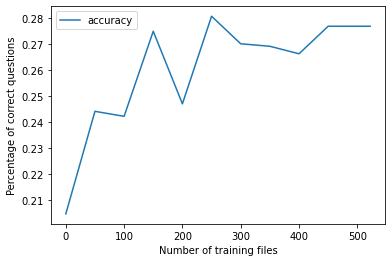

In [583]:
plt.plot(files_num,tri_scores,label='accuracy')
plt.xlabel("Number of training files")
plt.ylabel("Percentage of correct questions")
plt.legend(loc='upper left')
plt.show()


<a id='ngram_hyper_2'></a> 

#### 2.3.2 The threshold frequency for unknown words

In [584]:
thresholds = []
thre_scores = []

for x in range(0, 20, 2):
    print(x)
    thresholds.append(x)
    mylm=language_model(files=trainingfiles[:150],known=x)
    thre_scores.append(SCC.predict_and_score("trigram", mylm))

0
Processing DYNMT10.TXT
Processing 09TOM10.TXT
Processing PRSIT10.TXT
Processing NWIND10.TXT
Processing BDAPH10.TXT
Processing COTRT10.TXT
Processing POISN10.TXT
Processing RNDBY10.TXT
Processing LAMEP10.TXT
Processing OAKDA10.TXT
Processing TGAMT210.TXT
Processing MSBIM10.TXT
Processing ALAMO10.TXT
Processing FRCUP10.TXT
Processing NABBY10.TXT
Processing THEEU10.TXT
Processing SNYBK10.TXT
Processing TLTTF10.TXT
Processing STROQ10.TXT
Processing LDASC10.TXT
Processing EMMA10.TXT
Processing DOMBY10.TXT
Processing THBTC10.TXT
Processing ZENDA10.TXT
Processing AOFBT10.TXT
Processing HARDT10.TXT
Processing TCNTR10.TXT
Processing CPRFD10.TXT
Processing DOLIT10.TXT
Processing SWGEM10.TXT
Processing WRAIR10.TXT
Processing TWOHE10.TXT
Processing SILVS10.TXT
Processing TESS10.TXT
Processing OURNG10.TXT
Processing ALTDD10.TXT
Processing 11WOZ10.TXT
Processing TWBGD10.TXT
Processing RBCRU10.TXT
Processing LNDLR10.TXT
Processing JUDE11.TXT
Processing NOTUN11.TXT
Processing SIOUX10.TXT
Processing 

Processing DTROY10.TXT
Processing SLGRL10.TXT
Processing SUMMR10.TXT
Processing ANDES10.TXT
Processing TOUCH10.TXT
Processing HBOSS10.TXT
Processing 21TOM10.TXT
Processing JUNGL10.TXT
Processing CONFI10.TXT
Processing MORLL10.TXT
Processing MDKNG10.TXT
Processing NTNTN10.TXT
Processing IVNHO12.TXT
Processing OTORN10.TXT
Processing VIFRY10.TXT
Processing BLAGO10.TXT
Processing TREAS10.TXT
Processing CHOUR10.TXT
Processing DSTHJ10.TXT
Processing CKDEC10.TXT
Processing PHIL410.TXT
Processing 1ARGN10.TXT
Processing ISLNI10.TXT
Processing TMANS10.TXT
Processing 1ADAM10.TXT
Processing MOON10.TXT
Processing RBCR210.TXT
Processing 10WOZ10.TXT
Processing BICAR10.TXT
Processing RD2OZ10.TXT
Processing MANSF10.TXT
Processing HHOTL10.TXT
Processing HDKNK10.TXT
Processing KIDS110.TXT
Processing WIZOZ10.TXT
Processing ACHOE10.TXT
Processing CHILC10.TXT
Processing DWARE10.TXT
Processing TGAMT10.TXT
Processing MNBTW10.TXT
Processing FIVIT10.TXT
Processing ECORE10.TXT
Processing FSRGS10.TXT
Processing W

Processing TMUCK10.TXT
Processing DRDAY10.TXT
Processing 5DFRE10.TXT
Processing ANVER10.TXT
Processing RMEND10.TXT
Processing REZNV10.TXT
Processing MGOTS10.TXT
Processing RNDUP10.TXT
Processing 1MLKD11.TXT
Processing TNGLW10.TXT
Processing MSTNF10.TXT
Processing AHERO10.TXT
Processing BCPTV10.TXT
Processing SSEAS10.TXT
Processing DUGLAS11.TXT
Processing 3ELPH10.TXT
Processing 04TOM10.TXT
Processing PALIN10.TXT
Processing BADGE10.TXT
Processing 05TOM10.TXT
Processing ENOCH10.TXT
Processing YLFRY10.TXT
Processing AMBAS10.TXT
Processing TRED110.TXT
Processing HBOOK10.TXT
Processing WNLAW10.TXT
Processing PCRCS10.TXT
Processing LPRSS11.TXT
Processing SCARP10.TXT
Processing MAROG10.TXT
Processing BEQST11.TXT
Processing TSOPR09.TXT
Processing YANKE11.TXT
Processing AMATC10.TXT
Processing TWILS10.TXT
Processing BMINE10.TXT
10
Processing DYNMT10.TXT
Processing 09TOM10.TXT
Processing PRSIT10.TXT
Processing NWIND10.TXT
Processing BDAPH10.TXT
Processing COTRT10.TXT
Processing POISN10.TXT
Process

Processing EMMA10.TXT
Processing DOMBY10.TXT
Processing THBTC10.TXT
Processing ZENDA10.TXT
Processing AOFBT10.TXT
Processing HARDT10.TXT
Processing TCNTR10.TXT
Processing CPRFD10.TXT
Processing DOLIT10.TXT
Processing SWGEM10.TXT
Processing WRAIR10.TXT
Processing TWOHE10.TXT
Processing SILVS10.TXT
Processing TESS10.TXT
Processing OURNG10.TXT
Processing ALTDD10.TXT
Processing 11WOZ10.TXT
Processing TWBGD10.TXT
Processing RBCRU10.TXT
Processing LNDLR10.TXT
Processing JUDE11.TXT
Processing NOTUN11.TXT
Processing SIOUX10.TXT
Processing KDNPD10.TXT
Processing HRLND10.TXT
Processing SJV0410.TXT
Processing MAYRC10.TXT
Processing SHLIN10.TXT
Processing STRKM10.TXT
Processing 7GABL10.TXT
Processing ENYEW10.TXT
Processing LDORT10.TXT
Processing TBSCC10.TXT
Processing RAFLS10.TXT
Processing AMRNT10.TXT
Processing 2DINA10.TXT
Processing RDFRY10.TXT
Processing DTROY10.TXT
Processing SLGRL10.TXT
Processing SUMMR10.TXT
Processing ANDES10.TXT
Processing TOUCH10.TXT
Processing HBOSS10.TXT
Processing 21T

Processing PHIL410.TXT
Processing 1ARGN10.TXT
Processing ISLNI10.TXT
Processing TMANS10.TXT
Processing 1ADAM10.TXT
Processing MOON10.TXT
Processing RBCR210.TXT
Processing 10WOZ10.TXT
Processing BICAR10.TXT
Processing RD2OZ10.TXT
Processing MANSF10.TXT
Processing HHOTL10.TXT
Processing HDKNK10.TXT
Processing KIDS110.TXT
Processing WIZOZ10.TXT
Processing ACHOE10.TXT
Processing CHILC10.TXT
Processing DWARE10.TXT
Processing TGAMT10.TXT
Processing MNBTW10.TXT
Processing FIVIT10.TXT
Processing ECORE10.TXT
Processing FSRGS10.TXT
Processing WOODL10.TXT
Processing PETER16.TXT
Processing MRAMN10.TXT
Processing PORAP10.TXT
Processing MNSTR10.TXT
Processing MSBID10.TXT
Processing WWILL10.TXT
Processing SNOWI10.TXT
Processing RDDSK10.TXT
Processing AMNTS10.TXT
Processing TWPOP10.TXT
Processing OOTMA10.TXT
Processing MAGI10.TXT
Processing 10EVM10.TXT
Processing TMUCK10.TXT
Processing DRDAY10.TXT
Processing 5DFRE10.TXT
Processing ANVER10.TXT
Processing RMEND10.TXT
Processing REZNV10.TXT
Processing MG

In [585]:
thre_scores

[0.25576923076923075,
 0.2605769230769231,
 0.23846153846153847,
 0.2586538461538462,
 0.2528846153846154,
 0.2528846153846154,
 0.2519230769230769,
 0.2865384615384615,
 0.24615384615384617,
 0.275]

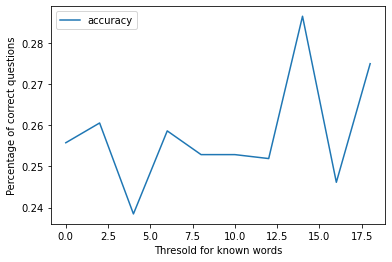

In [586]:
plt.plot(thresholds,thre_scores,label='accuracy')
plt.xlabel("Thresold for known words")
plt.ylabel("Percentage of correct questions")
plt.legend(loc='upper left')
plt.show()


In [587]:
thresholds

[0, 2, 4, 6, 8, 10, 12, 14, 16, 18]

<a id='ngram_hyper_3'></a> 

#### 2.3.3 The size of the discount applied to observed trigrams

In [588]:
discounts = []
dis_scores = []

for x in np.arange(0, 2.25, 0.25): 
    print(x)
    discounts.append(x)
    mylm=language_model(files=trainingfiles[:150],known=2, discount=x)
    dis_scores.append(SCC.predict_and_score("trigram", mylm))

0.0
Processing DYNMT10.TXT
Processing 09TOM10.TXT
Processing PRSIT10.TXT
Processing NWIND10.TXT
Processing BDAPH10.TXT
Processing COTRT10.TXT
Processing POISN10.TXT
Processing RNDBY10.TXT
Processing LAMEP10.TXT
Processing OAKDA10.TXT
Processing TGAMT210.TXT
Processing MSBIM10.TXT
Processing ALAMO10.TXT
Processing FRCUP10.TXT
Processing NABBY10.TXT
Processing THEEU10.TXT
Processing SNYBK10.TXT
Processing TLTTF10.TXT
Processing STROQ10.TXT
Processing LDASC10.TXT
Processing EMMA10.TXT
Processing DOMBY10.TXT
Processing THBTC10.TXT
Processing ZENDA10.TXT
Processing AOFBT10.TXT
Processing HARDT10.TXT
Processing TCNTR10.TXT
Processing CPRFD10.TXT
Processing DOLIT10.TXT
Processing SWGEM10.TXT
Processing WRAIR10.TXT
Processing TWOHE10.TXT
Processing SILVS10.TXT
Processing TESS10.TXT
Processing OURNG10.TXT
Processing ALTDD10.TXT
Processing 11WOZ10.TXT
Processing TWBGD10.TXT
Processing RBCRU10.TXT
Processing LNDLR10.TXT
Processing JUDE11.TXT
Processing NOTUN11.TXT
Processing SIOUX10.TXT
Processin

Processing RDFRY10.TXT
Processing DTROY10.TXT
Processing SLGRL10.TXT
Processing SUMMR10.TXT
Processing ANDES10.TXT
Processing TOUCH10.TXT
Processing HBOSS10.TXT
Processing 21TOM10.TXT
Processing JUNGL10.TXT
Processing CONFI10.TXT
Processing MORLL10.TXT
Processing MDKNG10.TXT
Processing NTNTN10.TXT
Processing IVNHO12.TXT
Processing OTORN10.TXT
Processing VIFRY10.TXT
Processing BLAGO10.TXT
Processing TREAS10.TXT
Processing CHOUR10.TXT
Processing DSTHJ10.TXT
Processing CKDEC10.TXT
Processing PHIL410.TXT
Processing 1ARGN10.TXT
Processing ISLNI10.TXT
Processing TMANS10.TXT
Processing 1ADAM10.TXT
Processing MOON10.TXT
Processing RBCR210.TXT
Processing 10WOZ10.TXT
Processing BICAR10.TXT
Processing RD2OZ10.TXT
Processing MANSF10.TXT
Processing HHOTL10.TXT
Processing HDKNK10.TXT
Processing KIDS110.TXT
Processing WIZOZ10.TXT
Processing ACHOE10.TXT
Processing CHILC10.TXT
Processing DWARE10.TXT
Processing TGAMT10.TXT
Processing MNBTW10.TXT
Processing FIVIT10.TXT
Processing ECORE10.TXT
Processing F

Processing TMUCK10.TXT
Processing DRDAY10.TXT
Processing 5DFRE10.TXT
Processing ANVER10.TXT
Processing RMEND10.TXT
Processing REZNV10.TXT
Processing MGOTS10.TXT
Processing RNDUP10.TXT
Processing 1MLKD11.TXT
Processing TNGLW10.TXT
Processing MSTNF10.TXT
Processing AHERO10.TXT
Processing BCPTV10.TXT
Processing SSEAS10.TXT
Processing DUGLAS11.TXT
Processing 3ELPH10.TXT
Processing 04TOM10.TXT
Processing PALIN10.TXT
Processing BADGE10.TXT
Processing 05TOM10.TXT
Processing ENOCH10.TXT
Processing YLFRY10.TXT
Processing AMBAS10.TXT
Processing TRED110.TXT
Processing HBOOK10.TXT
Processing WNLAW10.TXT
Processing PCRCS10.TXT
Processing LPRSS11.TXT
Processing SCARP10.TXT
Processing MAROG10.TXT
Processing BEQST11.TXT
Processing TSOPR09.TXT
Processing YANKE11.TXT
Processing AMATC10.TXT
Processing TWILS10.TXT
Processing BMINE10.TXT
1.25
Processing DYNMT10.TXT
Processing 09TOM10.TXT
Processing PRSIT10.TXT
Processing NWIND10.TXT
Processing BDAPH10.TXT
Processing COTRT10.TXT
Processing POISN10.TXT
Proce

Processing EMMA10.TXT
Processing DOMBY10.TXT
Processing THBTC10.TXT
Processing ZENDA10.TXT
Processing AOFBT10.TXT
Processing HARDT10.TXT
Processing TCNTR10.TXT
Processing CPRFD10.TXT
Processing DOLIT10.TXT
Processing SWGEM10.TXT
Processing WRAIR10.TXT
Processing TWOHE10.TXT
Processing SILVS10.TXT
Processing TESS10.TXT
Processing OURNG10.TXT
Processing ALTDD10.TXT
Processing 11WOZ10.TXT
Processing TWBGD10.TXT
Processing RBCRU10.TXT
Processing LNDLR10.TXT
Processing JUDE11.TXT
Processing NOTUN11.TXT
Processing SIOUX10.TXT
Processing KDNPD10.TXT
Processing HRLND10.TXT
Processing SJV0410.TXT
Processing MAYRC10.TXT
Processing SHLIN10.TXT
Processing STRKM10.TXT
Processing 7GABL10.TXT
Processing ENYEW10.TXT
Processing LDORT10.TXT
Processing TBSCC10.TXT
Processing RAFLS10.TXT
Processing AMRNT10.TXT
Processing 2DINA10.TXT
Processing RDFRY10.TXT
Processing DTROY10.TXT
Processing SLGRL10.TXT
Processing SUMMR10.TXT
Processing ANDES10.TXT
Processing TOUCH10.TXT
Processing HBOSS10.TXT
Processing 21T

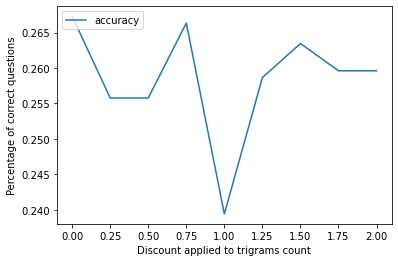

In [589]:
plt.plot(discounts,dis_scores,label='accuracy')
plt.xlabel("Discount applied to trigrams count")
plt.ylabel("Percentage of correct questions")
plt.legend(loc='upper left')
plt.show()


<a id='ngram_accuracy'></a> 

### 2.4 Ngram accuracy

In [664]:
mylm=language_model(files=trainingfiles)

Processing DYNMT10.TXT
Processing 09TOM10.TXT
Processing PRSIT10.TXT
Processing NWIND10.TXT
Processing BDAPH10.TXT
Processing COTRT10.TXT
Processing POISN10.TXT
Processing RNDBY10.TXT
Processing LAMEP10.TXT
Processing OAKDA10.TXT
Processing TGAMT210.TXT
Processing MSBIM10.TXT
Processing ALAMO10.TXT
Processing FRCUP10.TXT
Processing NABBY10.TXT
Processing THEEU10.TXT
Processing SNYBK10.TXT
Processing TLTTF10.TXT
Processing STROQ10.TXT
Processing LDASC10.TXT
Processing EMMA10.TXT
Processing DOMBY10.TXT
Processing THBTC10.TXT
Processing ZENDA10.TXT
Processing AOFBT10.TXT
Processing HARDT10.TXT
Processing TCNTR10.TXT
Processing CPRFD10.TXT
Processing DOLIT10.TXT
Processing SWGEM10.TXT
Processing WRAIR10.TXT
Processing TWOHE10.TXT
Processing SILVS10.TXT
Processing TESS10.TXT
Processing OURNG10.TXT
Processing ALTDD10.TXT
Processing 11WOZ10.TXT
Processing TWBGD10.TXT
Processing RBCRU10.TXT
Processing LNDLR10.TXT
Processing JUDE11.TXT
Processing NOTUN11.TXT
Processing SIOUX10.TXT
Processing KD

Processing STPIO10.TXT
Processing MASAC10.TXT
Processing PCLP110.TXT
Processing WWHIT10.TXT
Processing AGINO10.TXT
Processing GRTTR10.TXT
Processing TTNIC10.TXT
Processing WARW11.TXT
Processing BCITY10.TXT
Processing NBRBL10.TXT
Processing GMANS10.TXT
Processing PICIT10.TXT
Processing TBTIC10.TXT
Processing OCTOP10.TXT
Processing MOONA10.TXT
Processing THARV10.TXT
Processing PRGOB10.TXT
Processing SKYGM10.TXT
Processing WTFNG10.TXT
Processing WMARS12.TXT
Processing HLDRM10.TXT
Processing MDFOG10.TXT
Processing OWLCR10.TXT
Processing RHOLM11B.TXT
Processing AESOP11.TXT
Processing MOLLF10.TXT
Processing DLION10.TXT
Processing 09WOZ10.TXT
Processing TRAMP11.TXT
Processing INFRB10.TXT
Processing RUNNG10.TXT
Processing GABRM10.TXT
Processing TSHAK10.TXT
Processing EMAMC10.TXT
Processing BLIXN10.TXT
Processing SBBOZ10.TXT
Processing ATCOR10.TXT
Processing TYIFC10.TXT
Processing MOHIC10.TXT
Processing CNTMI10.TXT
Processing BLFRY10.TXT
Processing SONSA11.TXT
Processing JNGLB10.TXT
Processing 

0.24903846153846154

In [667]:
SCC.predict_and_score("unigram", mylm)

0.24903846153846154

In [665]:
SCC.predict_and_score("bigram", mylm)

0.27115384615384613

In [666]:
SCC.predict_and_score("trigram", mylm)

0.2778846153846154

<a id='trigram_error_analysis'></a> 

### 2.5 Trigram error analysis

In [601]:
# Adding correct answers to the question dataframe
ls = []
for line in lines_ans:
    ls.append(line[1])
    
qs_df['answer']=ls[1:]
qs_df.head()

,id,question,a),b),c),d),e),tokens,left_context,answer
0,1,I have it from the same source that you are bo...,crying,instantaneously,residing,matched,walking,"[I, have, it, from, the, same, source, that, y...","[and, are]",c
1,2,It was furnished partly as a sitting and partl...,daintily,privately,inadvertently,miserably,comfortably,"[It, was, furnished, partly, as, a, sitting, a...","[flowers, arranged]",a
2,3,"As I descended , my old ally , the _____ , cam...",gods,moon,panther,guard,country-dance,"[As, I, descended, ,, my, old, ally, ,, the, _...","[,, the]",d
3,4,"We got off , _____ our fare , and the trap rat...",rubbing,doubling,paid,naming,carrying,"[We, got, off, ,, _____, our, fare, ,, and, th...","[off, ,]",c
4,5,"He held in his hand a _____ of blue paper , sc...",supply,parcel,sign,sheet,chorus,"[He, held, in, his, hand, a, _____, of, blue, ...","[hand, a]",d


In [602]:
qs_df['trigram'] = SCC.predict("trigram", mylm)

In [629]:
#Check if these correct answers are by chance or because of the dictionary distribution

right_ans = qs_df[qs_df['trigram'] == qs_df['answer']]
wrong_ans = qs_df[qs_df['trigram'] != qs_df['answer']]
right_ans.head()

,id,question,a),b),c),d),e),tokens,left_context,answer,trigram
5,6,"Finally he returned to the pawnbroker's , and ...",balloon,stick,niece,beard,suit,"[Finally, he, returned, to, the, pawnbroker, '...","[with, his]",b,b
21,22,"Whatever his crimes , he has _____ something t...",suffered,touched,taught,forgotten,eaten,"[Whatever, his, crimes, ,, he, has, _____, som...","[he, has]",a,a
25,26,He hammered loudly at the _____ and pulled at ...,whelps,knocker,barn,tumult,vegetables,"[He, hammered, loudly, at, the, _____, and, pu...","[at, the]",b,b
27,28,"This , of course , fitted in well enough with ...",mystic,inevitable,police,customary,dreary,"[This, ,, of, course, ,, fitted, in, well, eno...","[with, the]",c,c
29,30,"The J. P shrugged his shoulders , and led the ...",downfall,abilities,symptoms,chamber,government,"[The, J., P, shrugged, his, shoulders, ,, and,...","[his, own]",d,d


In [623]:
tri_keys=list(mylm.trigram.keys())

In [628]:
count=0
for i in right_ans['left_context']:
    if tuple(i) in tri_keys:
        count+=1

count/len(right_ans['left_context'])

0.9454545454545454

In [631]:
count=0
for i in wrong_ans['left_context']:
    if tuple(i) in tri_keys:
        count+=1

count/len(wrong_ans['left_context'])

0.9437908496732026

The conclusion from the previous analysis is that both the trigram for the questions who were answered correctly and the ones who were answered with the wrong choice were found within the trigram dictionary by 94%. This means the training data was good enough to train and judge the model, and to conclude more context should be used ex:quadrigram or more.  

In [632]:
#Looking at the context of the questions, it looks like there can be many words to complement each pair and it is expected
#for the model not to behave in a good way

for i in wrong_ans['left_context']:
    if tuple(i) in tri_keys:
        print(i)

['and', 'are']
[',', 'the']
['off', ',']
['hand', 'a']
['is', 'no']
['between', 'the']
['a', 'little']
['sat', 'waiting']
['hand', 'and']
['few', 'faint']
['is', 'a']
['came', 'three']
['an', 'enthusiastic']
['have', 'his']
['specialist', 'was']
['for', 'he']
['with', 'the']
['the', 'solitary']
[',', 'a']
['imagine', 'my']
['me', 'my']
['loved', 'the']
['I', 'could']
['as', 'I']
['was', 'a']
['his', 'own']
['and', 'the']
['screamed', 'and']
['used', 'by']
['I', 'carefully']
['back', 'without']
['know', 'the']
['one', 'may']
['raised', 'the']
['details', 'have']
['received', 'an']
['actually', 'sat']
['you', 'were']
['arteries', 'which']
['fat', 'man']
['but', 'is']
['to', 'make']
['I', 'have']
['as', 'I']
['but', 'we']
['in', 'the']
['Perhaps', 'our']
['that', 'the']
['and', 'the']
['Then', 'he']
['Not', 'a']
['fear', 'to']
['upon', 'a']
['tell', 'what']
['almost', 'as']
['of', 'the']
['the', 'criminal']
['they', 'quite']
['I', 'ever']
['to', 'have']
['were', 'the']
['darkness', 'was']

["'", 'face']
['as', 'the']
['even', 'my']
['was', 'very']
['I', 'will']
['was', 'a']
['any', 'strong']
['He', 'had']
['inspector', 'had']
['which', 'had']
['way', 'to']
['along', 'the']
['saw', 'that']
['time', ',']
['of', 'the']
['the', 'great']
['was', 'the']
['time', 'after']
['it', 'to']
['there', 'were']
[',', 'and']
['flame', 'which']
['been', 'terribly']
['face', 'the']
['the', 'British']
['trees', 'was']
['the', 'fruit']
['from', 'the']
['had', 'turned']
['little', 'more']
['never', 'trouble']
['a', 'smarter']
['to', 'be']
['and', 'on']
['must', 'be']
['life', 'was']
['collection', 'of']
['flush', 'had']
['with', 'something']
['had', 'been']
['face', 'was']
[',', 'his']
['had', 'so']
['upon', 'this']
['door', 'slammed']
['he', 'must']
['stood', 'a']
['in', 'a']
['prevents', 'any']
['like', 'a']
['Colonel', "'s"]
['of', 'the']
['was', 'one']
['Half', 'a']
['but', 'she']
['his', 'hat']
['were', 'all']
['implored', 'the']
['be', 'the']
['that', 'his']
['made', 'an']
['in', 'the']

<a id='word_similarity'></a> 

## 3 Word similarity method

<a id='word_embeddings'></a> 

### 3.1 Load word embeddings

In [121]:
filename="GoogleNews-vectors-negative300.bin"
mymodel = KeyedVectors.load_word2vec_format(filename, binary=True)

<a id='similarity_classes'></a> 

### 3.2 Similarity model classes

In [521]:
class similarity_model():
    
    def clean_sen(self, tokens):
        #Deleteing the stop words as they are not included in the word embedding and it won't affect the similarity measure
        stop = stopwords.words('english')
        s =  set(string.punctuation)
        #Some of the tokens within the questions are combined and they needed to be handled to avoid a key error
        #This will consider each one of them as a word and calculate its similarity with the other words then sum 
        #the total for both of them
        #After the split the tokens will be a list of lists and that's why sum(ls,[]) is used to flatten it 
        filtered=sum([word.split('-') for word in tokens if  word not in s and word not in stop], [])
        return filtered
    
    def get_sim(self,choice,tokens):
        #Same problem of combined words is handled within the choices 
        choice_sep = choice.split('-')
        filtered = self.clean_sen(tokens)
        #List of words to exclude because they aren't found within the file
        del_ls = ['__START','__END',"'s", 'rumours']
        in_sim=0
        out_sim=0
        #nested for loop to handle the combined choices like police-station because after the split it will be 
        #['police', 'station'] and every word needs to be considered with the whole list of tokens
        for ch_ in choice_sep:
            for token in filtered:
                if token in del_ls or ch_ in del_ls or token not in mymodel.vocab or choice not in mymodel.vocab:
                    continue
                in_sim+= mymodel.similarity(ch_,token) 
            out_sim+=in_sim
        return out_sim

<a id='Similarity_acc'></a> 

#### 3.2.1 Similarity model accuracy

In [522]:
#Calculate the accuracy of the similarity method

mylm=similarity_model()
SCC.predict_and_score("similarity", mylm)

0.36346153846153845

In [524]:
#Check the predictions aren't changing as an indication of the sucessful prediction step, because if the predictions are
#changing then the random return within the choice function will lead to a continous change in this list 

SCC.predict("similarity", mylm)

['a',
 'e',
 'd',
 'c',
 'd',
 'b',
 'd',
 'a',
 'c',
 'a',
 'c',
 'b',
 'd',
 'e',
 'c',
 'c',
 'e',
 'b',
 'b',
 'b',
 'd',
 'd',
 'e',
 'd',
 'd',
 'b',
 'e',
 'b',
 'c',
 'a',
 'c',
 'e',
 'd',
 'c',
 'c',
 'b',
 'a',
 'e',
 'd',
 'a',
 'c',
 'd',
 'e',
 'a',
 'b',
 'a',
 'd',
 'e',
 'e',
 'd',
 'c',
 'b',
 'c',
 'a',
 'b',
 'c',
 'b',
 'c',
 'b',
 'b',
 'b',
 'd',
 'e',
 'b',
 'd',
 'a',
 'a',
 'b',
 'c',
 'b',
 'd',
 'e',
 'c',
 'b',
 'b',
 'd',
 'e',
 'd',
 'd',
 'b',
 'a',
 'e',
 'b',
 'd',
 'c',
 'b',
 'e',
 'e',
 'c',
 'a',
 'b',
 'c',
 'c',
 'd',
 'd',
 'b',
 'd',
 'e',
 'c',
 'b',
 'd',
 'a',
 'd',
 'd',
 'd',
 'e',
 'd',
 'e',
 'e',
 'a',
 'b',
 'd',
 'd',
 'c',
 'c',
 'c',
 'e',
 'c',
 'a',
 'a',
 'b',
 'd',
 'd',
 'b',
 'a',
 'a',
 'c',
 'e',
 'd',
 'c',
 'e',
 'a',
 'a',
 'b',
 'd',
 'e',
 'd',
 'd',
 'c',
 'b',
 'a',
 'a',
 'b',
 'c',
 'b',
 'a',
 'b',
 'd',
 'c',
 'a',
 'a',
 'a',
 'a',
 'e',
 'c',
 'a',
 'd',
 'a',
 'c',
 'e',
 'a',
 'd',
 'd',
 'c',
 'b',
 'e',
 'e'

<a id='similarity_hyper_parameters'></a> 

### 3.3 Similarity method hyper-parameters

<a id='embeddings_count'></a> 

#### 3.3.1 The number of the embeddings used to calculate the similarity

In [537]:
# Test the effect of using more word embeddings from 300k, 600k, 900k... 3million vectors 
emb_len = []
emb_score = []
for i in range(0,11):
    emb_len.append(300000*i)
    mymodel = KeyedVectors.load_word2vec_format(filename, binary=True, limit=300000*i)
    print(300000*i, 'loaded')
    emb_score.append(SCC.predict_and_score("similarity", mylm))

0 loaded
300000 loaded
600000 loaded
900000 loaded
1200000 loaded
1500000 loaded
1800000 loaded
2100000 loaded
2400000 loaded
2700000 loaded
3000000 loaded


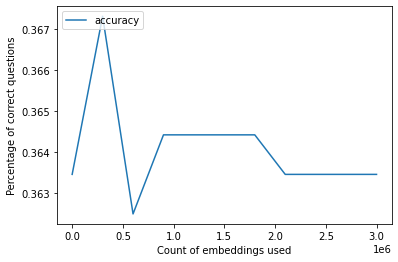

In [539]:
plt.plot(emb_len,emb_score,label='accuracy')
plt.xlabel("Count of embeddings used")
plt.ylabel("Percentage of correct questions")
plt.legend(loc='upper left')
plt.show()


This graph shows that starting 300k embeddings, the accuracy is almost the same. This means that the Googlenews vectors are ordered according to frequency and the most 300k vectors were enough to cover same number of tokens as the 300k vectors.

In [575]:
# looking at the perentage of tokens within the questions found while using only 30k vectors, and comparing it to the 300k to 
# double check it's almost the same

mymodel = KeyedVectors.load_word2vec_format(filename, binary=True, limit=300000)

count_ls=0
for token in ls_:
    if token in mymodel.vocab:
        count_ls+=1   
print('Percentage of list tokens found within the corpus', count_ls/len(ls_) *100, '%')

Percentage of list tokens found within the corpus 79.08222480135703 %


<a id='similarity_error_analysis'></a> 

### 3.4 Similarity method error analysis


In [560]:
#Creating ls_ of the tokens that weren't found within the word embeddings, and token_set of the unique tokens 
#that weren't found within the word embeddings to assess their percentages and effect on the accuracy

ls_=[]
for tokens in qs_df['tokens']:
    for token in tokens:
        ls_.append(token)
tokens_set = set(ls_)

count_set=0
count_ls=0
for token in tokens_set:
    if token in mymodel.vocab:
        count_set+=1

for token in ls_:
    if token in mymodel.vocab:
        count_ls+=1        
print('Percentage of set tokens found within the corpus', count_set/len(tokens_set) *100, '%')
print('Percentage of list tokens found within the corpus', count_ls/len(ls_) *100, '%')

Percentage of set tokens found within the corpus 97.056 %
Percentage of list tokens found within the corpus 79.30541915900366 %


The tokens that are part of the question and not part of the word embeddings are mostly the stop words, and they will not make a difference in calculating the overall similarity. Therefore, the results we are having is a good judgement on the performance of the similarity method when used to complete the Microsoft challenge. 
The combined words like 'police-station' are handled within the 'get_sim' function, but was ignored in the analysis here for simplicity  


In [563]:
#Counting the frequency of the tokens within the questions and not found within the word embeddings

not_found={}
for token in ls_:
    if token not in mymodel.vocab:
        not_found[token] = not_found.get(token, 0)+1
not_found

{'and': 673,
 'a': 522,
 '.': 1041,
 ',': 1160,
 'of': 542,
 'to': 520,
 "'s": 52,
 'smooth-faced': 1,
 'worm-eaten': 1,
 'discoloured': 1,
 'bell-pull': 3,
 'four-year-old': 1,
 'arm-chair': 2,
 'blotting-paper': 1,
 'police-station': 1,
 'dressing-gown': 5,
 ';': 9,
 'to-night': 1,
 'ecarte': 1,
 'reasoner': 1,
 'well-grown': 1,
 "'": 10,
 'old-fashioned': 3,
 'honourable': 1,
 'labour': 1,
 'dressing-room': 1,
 'ever-changing': 1,
 'sitting-room': 4,
 'programme': 1,
 'centre': 4,
 'consulting-room': 4,
 'dining-room': 1,
 'morning-room': 1,
 'quarter-past': 1,
 'smoking-room': 1,
 'travelled': 2,
 'country-houses': 1,
 'whipcord': 2,
 'ill-health': 1,
 'window-sill': 1,
 'manor-house': 1,
 '30,000': 1,
 'practised': 1,
 'top-hat': 1,
 'half-pay': 1,
 'battle-axe': 1,
 'saviour': 1,
 'coal-black': 1,
 'panelled': 1,
 'good-day': 1,
 'billiard-room': 1,
 "'Hullo": 2,
 'hansoms': 1,
 'door-key': 1,
 'fellow-countryman': 1,
 'to-day': 1,
 'bell-rope': 2,
 'dog-cart': 1,
 'left-hand': 1

- <a href='#error_analysis'>4 Error analysis</a>
    - <a href='#word_error'>4.1 Trigram error analysis</a>
    - <a href='#similarity_error'>4.2 Similarity error analysis</a>

<a id='Common_error_analysis'></a> 

## 4 Common eror analysis

In [633]:
#Adding the answers predicted by the similarity model to use it in the analysis 

mylm=similarity_model()
qs_df['similarity'] = SCC.predict("similarity", mylm)

In [635]:
qs_df.head()

,id,question,a),b),c),d),e),tokens,left_context,answer,trigram,similarity
0,1,I have it from the same source that you are bo...,crying,instantaneously,residing,matched,walking,"[I, have, it, from, the, same, source, that, y...","[and, are]",c,b,a
1,2,It was furnished partly as a sitting and partl...,daintily,privately,inadvertently,miserably,comfortably,"[It, was, furnished, partly, as, a, sitting, a...","[flowers, arranged]",a,b,e
2,3,"As I descended , my old ally , the _____ , cam...",gods,moon,panther,guard,country-dance,"[As, I, descended, ,, my, old, ally, ,, the, _...","[,, the]",d,b,d
3,4,"We got off , _____ our fare , and the trap rat...",rubbing,doubling,paid,naming,carrying,"[We, got, off, ,, _____, our, fare, ,, and, th...","[off, ,]",c,e,c
4,5,"He held in his hand a _____ of blue paper , sc...",supply,parcel,sign,sheet,chorus,"[He, held, in, his, hand, a, _____, of, blue, ...","[hand, a]",d,b,d


In [639]:
# total number of wrong predictions done by the trigram model

len(qs_df[qs_df['answer'] != qs_df['trigram']])

765

In [658]:
# total errors done by both models

len(qs_df[(qs_df['answer'] != qs_df['trigram']) & (qs_df['answer'] != qs_df['similarity'])])/765

0.6601307189542484

In [659]:
# total errors done by similarity and not done by trigram

len(qs_df[(qs_df['answer'] == qs_df['trigram']) & (qs_df['answer'] != qs_df['similarity'])])/765

0.2

In [662]:
# total errors done by trigram and not done by similarity

len(qs_df[(qs_df['answer'] != qs_df['trigram']) & (qs_df['answer'] == qs_df['similarity'])])/765

0.33986928104575165

The conclusion from these numbers is that, there are questions that were predicted correctly by the trigram model and missed by the similarity model, which means using a join model might enhance the overall accuracy. 
The overall performance of the similarity model is better than the trigram model.

In [655]:
#Looking at some of the common mistakes to see if there is a pattern leading to them

qs_df[(qs_df['answer'] != qs_df['trigram']) & (qs_df['answer'] != qs_df['similarity'])].head()

,id,question,a),b),c),d),e),tokens,left_context,answer,trigram,similarity
0,1,I have it from the same source that you are bo...,crying,instantaneously,residing,matched,walking,"[I, have, it, from, the, same, source, that, y...","[and, are]",c,b,a
1,2,It was furnished partly as a sitting and partl...,daintily,privately,inadvertently,miserably,comfortably,"[It, was, furnished, partly, as, a, sitting, a...","[flowers, arranged]",a,b,e
6,7,"There is no _____ between them , but they all ...",understanding,communication,difference,intrigue,issue,"[There, is, no, _____, between, them, ,, but, ...","[is, no]",b,e,d
7,8,He and I seemed to be the only living things b...,funniest,speedy,huge,actual,judicial,"[He, and, I, seemed, to, be, the, only, living...","[between, the]",c,d,a
10,11,She never said a word until we were at the doo...,telephoned,begged,kissed,helped,robbed,"[She, never, said, a, word, until, we, were, a...","[hand, and]",b,c,c


In [656]:
#Looking at some of the common mistakes 

qs_df[(qs_df['answer'] != qs_df['trigram']) & (qs_df['answer'] != qs_df['similarity'])].tail()

,id,question,a),b),c),d),e),tokens,left_context,answer,trigram,similarity
1032,1033,It was a quarter to ten before we reached Lond...,rolled,dined,fed,alighted,seized,"[It, was, a, quarter, to, ten, before, we, rea...","[of, us]",d,b,a
1033,1034,"The shape of some monstrous villainy , half se...",guessed,falling,beast,dazed,humming,"[The, shape, of, some, monstrous, villainy, ,,...","[,, half]",a,d,c
1035,1036,The bedrooms in this _____ are on the ground f...,wing,coach,balcony,kingdom,neighbourhood,"[The, bedrooms, in, this, _____, are, on, the,...","[in, this]",a,d,c
1036,1037,Our visitor bore every mark of being an averag...,blind,energetic,eloquent,pompous,sandy-haired,"[Our, visitor, bore, every, mark, of, being, a...","[obese, ,]",d,a,a
1038,1039,"It is your commonplace , _____ crimes which ar...",underlying,featureless,theological,flattering,inevitable,"[It, is, your, commonplace, ,, _____, crimes, ...","[commonplace, ,]",b,c,e
